In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from transformers import pipeline

from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

In [3]:
# load toxicity annotation model
toxpipe = pipeline("text-classification", model="cooperleong00/deberta-v3-large_toxicity-scorer")

## Wiki-Detox

In [32]:
# read in original data
df = pd.read_csv('../data/wiki-detox/original_detox.tsv',sep='\t')

# read in dialect subsets
aave = pd.read_json("../data/wiki-detox/aave_1k.jsonl", lines=True)
nigerianD = pd.read_json("../data/wiki-detox/nigerianD_1k.jsonl", lines=True)
indianD = pd.read_json("../data/wiki-detox/indianD_1k.jsonl", lines=True)
singlish = pd.read_json("../data/wiki-detox/singlish_1k.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
df_sample = df.iloc[:1000]

### run DeBERTa toxicity scorer on the original texts and all 4 dialects

In [33]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float) 
    
    return lconf

In [34]:
lconf_og_1k = get_label_confidence(df["comment"][:1000])
lconf_og_1k.to_csv("../data/wiki-detox/lconf_original_1k.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/wiki-detox/lconf_aave_1k.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/wiki-detox/lconf_nigerianD_1k.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/wiki-detox/lconf_indianD_1k.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/wiki-detox/lconf_singlish_1k.csv", sep=",", index=False)

100%|██████████| 1000/1000 [15:09<00:00,  1.10it/s] 


### check results on Wiki-Detox

In [35]:
# load saved predictions and check distribution of labels   
lconf_og_1k = pd.read_csv("../data/wiki-detox/lconf_original_1k.csv")
lconf_aave_1k = pd.read_csv("../data/wiki-detox/lconf_aave_1k.csv")
lconf_nigerianD_1k = pd.read_csv("../data/wiki-detox/lconf_nigerianD_1k.csv")
lconf_indianD_1k = pd.read_csv("../data/wiki-detox/lconf_indianD_1k.csv")
lconf_singlish_1k = pd.read_csv("../data/wiki-detox/lconf_singlish_1k.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({0.0: 964, 1.0: 36})
Counter({0.0: 963, 1.0: 37})
Counter({0.0: 965, 1.0: 35})
Counter({0.0: 966, 1.0: 34})
Counter({0.0: 963, 1.0: 37})


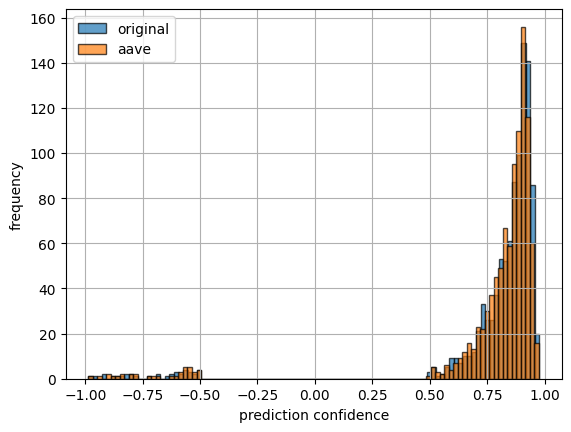

In [36]:
plt.hist(lconf_og_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="original")
plt.hist(lconf_aave_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="aave")
plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# KS test for prediction confidence on Wiki-Detox
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=0.07200, p=0.01119
Statistics=0.05600, p=0.08690
Statistics=0.05400, p=0.10829
Statistics=0.10100, p=0.00007


In [38]:
# Mann Whitney U test for prediction confidence on Wiki-Detox
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=532991.00000, p=0.01063
Statistics=527190.50000, p=0.03524
Statistics=522656.00000, p=0.07935
Statistics=549670.50000, p=0.00012


In [39]:
# overall prediction confidence
print("overall -----------------")
print(np.average([c for c in lconf_og_1k["confidence"]]))
print(np.average([c for c in lconf_aave_1k["confidence"]]))
print(np.average([c for c in lconf_nigerianD_1k["confidence"]]))
print(np.average([c for c in lconf_indianD_1k["confidence"]]))

# average confidence of toxic predictions  
print("toxic -------------------")
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c < 0]))

# average confidence of non-toxic predictions  
print("non-toxic ---------------")
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c > 0]))

overall -----------------
0.797173512518406
0.7897873908281327
0.7925030657052994
0.7966783827543259
toxic -------------------
0.6760093718767166
0.6629518866539001
0.671651726109641
0.6530748745974373
non-toxic ---------------
0.8521886409812943
0.8456039570449916
0.8456071255120589
0.8477048949178455


## Davidson's Twitter

In [40]:
# read in original data
df = pd.read_csv('../data/davidson/original_davidson.csv', sep=',', index_col=0)

# read in dialect subsets
aave = pd.read_json("../data//davidson/aave_1k.jsonl", lines=True)
nigerianD = pd.read_json("../data//davidson/nigerianD_1k.jsonl", lines=True)
indianD = pd.read_json("../data//davidson/indianD_1k.jsonl", lines=True)
singlish = pd.read_json("../data//davidson/singlish_1k.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
df_sample = df.iloc[:1000]

In [5]:
def get_label_confidence(sents):
    """functions for getting toxicity label and confidence score for a list of sentences"""
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float) 
    
    return lconf

In [42]:
lconf_og_1k = get_label_confidence(df_sample["tweet"][:1000])
lconf_og_1k.to_csv("../data/davidson/lconf_original_1k.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/davidson/lconf_aave_1k.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/davidson/lconf_nigerianD_1k.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/davidson/lconf_indianD_1k.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/davidson/lconf_singlish_1k.csv", sep=",", index=False)

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


### check results on Davidson's Twitter

In [43]:
# load saved predictions and check distribution of labels   
lconf_og_1k = pd.read_csv("../data/davidson/lconf_original_1k.csv")
lconf_aave_1k = pd.read_csv("../data/davidson/lconf_aave_1k.csv")
lconf_nigerianD_1k = pd.read_csv("../data/davidson/lconf_nigerianD_1k.csv")
lconf_indianD_1k = pd.read_csv("../data/davidson/lconf_indianD_1k.csv")
lconf_singlish_1k = pd.read_csv("../data/davidson/lconf_singlish_1k.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({1.0: 796, 0.0: 204})
Counter({1.0: 783, 0.0: 217})
Counter({1.0: 790, 0.0: 210})
Counter({1.0: 780, 0.0: 220})
Counter({1.0: 781, 0.0: 219})


In [44]:
# KS test for prediction confidence on Davidson
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=0.05100, p=0.14836
Statistics=0.03900, p=0.43261
Statistics=0.07000, p=0.01487
Statistics=0.04500, p=0.26347


In [45]:
# Mann Whitney U test for prediction confidence on Davidson
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=518620.00000, p=0.14933
Statistics=515604.00000, p=0.22692
Statistics=529029.00000, p=0.02458
Statistics=513923.50000, p=0.28094


## HateXplain Twitter

In [4]:
# read in original data
df = pd.read_json(f"../data/hatexplain/original_hatexplain.json").transpose()

# read in dialect subsets
aave = pd.read_json("../data/hatexplain/aave_1k.jsonl", lines=True)
nigerianD = pd.read_json("../data/hatexplain/nigerianD_1k.jsonl", lines=True)
indianD = pd.read_json("../data/hatexplain/indianD_1k.jsonl", lines=True)
singlish = pd.read_json("../data/hatexplain/singlish_1k.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
df_sample = df.iloc[:1000]

In [7]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float) 
    
    return lconf

In [14]:
sample_tweets = [" ".join(token_ls) for token_ls in list(df_sample["post_tokens"])]
lconf_og_1k = get_label_confidence(sample_tweets)
lconf_og_1k.to_csv("../data/hatexplain/lconf_original_1k.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/hatexplain/lconf_aave_1k.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/hatexplain/lconf_nigerianD_1k.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/hatexplain/lconf_indianD_1k.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/hatexplain/lconf_singlish_1k.csv", sep=",", index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


### check results on HateXplain Twitter

In [15]:
# load saved predictions and check distribution of labels   
lconf_og_1k = pd.read_csv("../data/hatexplain/lconf_original_1k.csv")
lconf_aave_1k = pd.read_csv("../data/hatexplain/lconf_aave_1k.csv")
lconf_nigerianD_1k = pd.read_csv("../data/hatexplain/lconf_nigerianD_1k.csv")
lconf_indianD_1k = pd.read_csv("../data/hatexplain/lconf_indianD_1k.csv")
lconf_singlish_1k = pd.read_csv("../data/hatexplain/lconf_singlish_1k.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({1.0: 789, 0.0: 211})
Counter({1.0: 779, 0.0: 221})
Counter({1.0: 783, 0.0: 217})
Counter({1.0: 759, 0.0: 241})
Counter({1.0: 777, 0.0: 223})


In [16]:
# test if lconf_og_1k is normally distributed
from scipy.stats import shapiro

stat, p = shapiro(lconf_og_1k["confidence"])
print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal

stat, p = shapiro(lconf_aave_1k["confidence"])
print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
stat, p = shapiro(lconf_nigerianD_1k["confidence"])
print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
stat, p = shapiro(lconf_indianD_1k["confidence"])
print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
stat, p = shapiro(lconf_singlish_1k["confidence"])
print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal

Statistics=6.968656e-01, p=5.423117e-39
Statistics=7.048653e-01, p=1.287301e-38
Statistics=7.037163e-01, p=1.135664e-38
Statistics=7.139208e-01, p=3.505483e-38
Statistics=7.027953e-01, p=1.027417e-38


In [17]:
# KS test for prediction confidence on Davidson
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=3.600000e-02, p=5.362767e-01
Statistics=3.000000e-02, p=7.593696e-01
Statistics=4.700000e-02, p=2.193965e-01
Statistics=3.000000e-02, p=7.593696e-01


In [18]:
# cross-dialect confidence differences (aave against other 3)
stat, p = ks_2samp([abs(c) for c in lconf_aave_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_aave_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_aave_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))

Statistics=2.600000e-02, p=8.881734e-01
Statistics=2.000000e-02, p=9.883340e-01
Statistics=2.700000e-02, p=8.595454e-01


In [19]:
# Mann Whitney U test for prediction confidence on Davidson
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=5.163175e+05, p=2.063759e-01
Statistics=5.141740e+05, p=2.723791e-01
Statistics=5.208575e+05, p=1.062733e-01
Statistics=5.100050e+05, p=4.384865e-01


In [20]:
# overall prediction confidence
print("overall -----------------")
print(np.average([c for c in lconf_og_1k["confidence"]]))
print(np.average([c for c in lconf_aave_1k["confidence"]]))
print(np.average([c for c in lconf_nigerianD_1k["confidence"]]))
print(np.average([c for c in lconf_indianD_1k["confidence"]]))
print(np.average([c for c in lconf_singlish_1k["confidence"]]))

# average confidence of toxic predictions  
print("toxic -------------------")
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_singlish_1k["confidence"] if c < 0]))

# average confidence of non-toxic predictions  
print("non-toxic ---------------")
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_singlish_1k["confidence"] if c > 0]))

overall -----------------
-0.5038449893593788
-0.48414558786153794
-0.49412602311372755
-0.4598774493932724
-0.4868043528795242
toxic -------------------
0.8199061554949849
0.8130947093602475
0.8154136493592731
0.8170967503341604
0.8187883813869079
non-toxic ---------------
0.6780140631571765
0.6753628539823299
0.6651744900211212
0.6651410129060389
0.6699292352381309


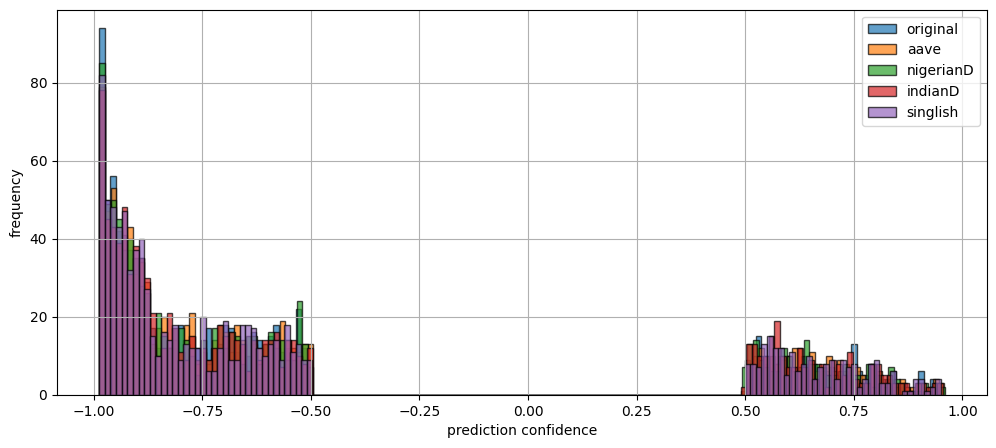

In [21]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(lconf_og_1k["confidence"], bins=150, edgecolor='black', alpha=0.7, label="original")
plt.hist(lconf_aave_1k["confidence"], bins=150, edgecolor='black', alpha=0.7, label="aave")
plt.hist(lconf_nigerianD_1k["confidence"], bins=150, edgecolor='black', alpha=0.7, label="nigerianD")
plt.hist(lconf_indianD_1k["confidence"], bins=150, edgecolor='black', alpha=0.7, label="indianD")
plt.hist(lconf_singlish_1k["confidence"], bins=150, edgecolor='black', alpha=0.7, label="singlish")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

## Compare the 3 datasets

In [55]:
detox = pd.read_csv('../data/wiki-detox/original_detox.tsv',sep='\t')
davidson = pd.read_csv('../data/davidson/original_davidson.csv', sep=',', index_col=0)
xplain = pd.read_json(f"../data/hatexplain/original_hatexplain.json").transpose()

In [72]:
# work on detox
sent_lens = []
for sent in detox["comment"]:
    token_ls = sent.split()
    sent_len = len(token_ls)
    sent_lens.append(sent_len)

mean_sent_len = np.mean(sent_lens)
print(mean_sent_len)

66.91229036985084


In [73]:
# work on davidson
sent_lens = []
for sent in davidson["tweet"]:
    token_ls = sent.split()
    sent_len = len(token_ls)
    sent_lens.append(sent_len)

mean_sent_len = np.mean(sent_lens)
print(mean_sent_len)

14.117015696243392


In [75]:
# work on hatexplain
sent_lens = []
for token_ls in xplain["post_tokens"]:
    sent_len = len(token_ls)
    sent_lens.append(sent_len)

mean_sent_len = np.mean(sent_lens)
print(mean_sent_len)

23.570279928528887


In [76]:
davidson.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [77]:
xplain.head()

,post_id,annotators,rationales,post_tokens
1179055004553900032_twitter,1179055004553900032_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[i, dont, think, im, getting, my, baby, them, ..."
1179063826874032128_twitter,1179063826874032128_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[we, cannot, continue, calling, ourselves, fem..."
1178793830532956161_twitter,1178793830532956161_twitter,"[{'label': 'normal', 'annotator_id': 4, 'targe...",[],"[nawt, yall, niggers, ignoring, me]"
1179088797964763136_twitter,1179088797964763136_twitter,"[{'label': 'hatespeech', 'annotator_id': 1, 't...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<user>, i, am, bit, confused, coz, chinese, p..."
1179085312976445440_twitter,1179085312976445440_twitter,"[{'label': 'hatespeech', 'annotator_id': 4, 't...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[this, bitch, in, whataburger, eating, a, burg..."
